<h1><font color='red'> THIS IS A SAMPLE SOLUTION FOR KNN WITH BOW REPRESENTATION OF ESSAY AND FEW OTHER FEATURES. <br><br> CONSIDERED ONLY 5K DATA POINTS, FOR YOUR ASSIGNMENT YOU MIGHT NEED TO CONSIDER ATLEAST 50K DATA POINTS, AND EXTRA FEATURES THAT ARE PROVIDED IN THE INSTRUCTIONS</font></h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from collections import Counter

<h1>1. K Nearest Neighbor</h1>

## 1.1 Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data  = pd.read_csv('/content/drive/MyDrive/Case Studies/6_Donors_choose_NB/preprocessed_data.csv', nrows=10000)
# data  = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis = 1)# axis = 1 means apply the function column wise 

X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
# train test split
from sklearn.model_selection import train_test_split

# X is a DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33, stratify = y_train)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [6]:
ex = [
      "classroom students should take break",
      "low income homes students receive free breakfast",
      "students will receive low grades"
      ]

vectorizer = CountVectorizer()
vectorizer.fit(ex)

print(vectorizer.transform(ex).toarray())
print(vectorizer.get_feature_names())

[[1 0 1 0 0 0 0 0 0 1 1 1 0]
 [0 1 0 1 0 1 1 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 0 1 0 1]]
['break', 'breakfast', 'classroom', 'free', 'grades', 'homes', 'income', 'low', 'receive', 'should', 'students', 'take', 'will']


In [7]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df = 10,ngram_range = (1,4), max_features = 5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow    = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow  = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")

print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


# print("YOU SHOULD NOT DO SOMETHING LIKE THIS")
# vectorizer = CountVectorizer()
# x_train_bow = vectorizer.fit_transform(X_train['essay'].values)
# x_cv_bow = vectorizer.fit_transform(X_cv['essay'].values)
# x_test_bow = vectorizer.fit_transform(X_test['essay'].values)

# print(x_train_bow.shape, y_train.shape)
# print(x_cv_bow.shape, y_cv.shape)
# print(x_test_bow.shape, y_test.shape)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(4489, 8) (4489,)
(2211, 8) (2211,)
(3300, 8) (3300,)
After vectorizations
(4489, 5000) (4489,)
(2211, 5000) (2211,)
(3300, 5000) (3300,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


<pre>
<h2> <font color='red'>YOU SHOULD NOT DO LIKE THIS </font></h2>
1.  <font color='red'>THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA</font>
    vectorizer = CountVectorizer()
    x_train_bow = vectorizer.fit_transform(X_train)
    x_cv_bow = vectorizer.fit_transform(X_cv)
    x_test_bow = vectorizer.fit_transform(X_test)
    
2.  <font color='red'>DATA LEAKAGE PROBLEM: IF WE DO LIKE THIS WE ARE LOOKING AT THE TEST DATA BEFORE MODELING</font>
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transfomr(X)
    X_train, X_test, y_train, y_test = train_test_split(X_bow, Y, test_size=0.33)
   
3. <font color='red'>YOU SHOULD PASS THE PROBABILITY SCORES NOT THE PREDICTED VALUES</font>
    y_pred =  neigh.predict(X)
    roc_auc_score(y_ture,y_pred)


</pre>

<pre>
<h2> <font color='red'>WHAT ARE THESE FUNCTIONS: FIT, TRANSFORM, FIT_TRANSFORM</font></h2>

When you do
<i><font color='blue'>vec =  CountVectorizer()</font></i>

then it will initiate the <i><font color='blue'>CountVectorizer</font></i> with default parameters.

<i><font color='blue'>vec.fit(Train_text)</font></i>: Means that internally it is only learning the vocabulary of `Text` i.e. unique n-grams

<i><font color='blue'>bag_of_words = vec.transform(Train_text)</font></i>: Means it is applying that learned parameters (vocabulary) to the data and thus giving you output i.e. words in Bag of words formate. 

Now, as you should know that the  <i>vocabulary(unique n-grams)</i> can be different for <i>Train Text</i> and <i>Test Text</i> thus they will give you different dimensional matrices for Train and Test. 

So what you should do is -  <i><font color='blue'>vec = CountVectorizer()</font></i>, <i><font color='blue'>vec.fit(Train_text)</font></i>

which learns the vocabulary of <i>Train Text</i> and then apply or transform your both <i>Train Text</i> and <i>Test Text</i>  using that  
learned vocabulary to ensure the same dimensions for both of them by doing -

<i><font color='blue'>bag_of_words_train = vec.transform(Train_text)</font></i>
and
<i><font color='blue'>bag_of_words_test = vec.transform(Test_text)</font></i>


so to conclude

<i><font color='blue'>
model =  CountVectorizer()
model.fit(train_text)
train_bow = model.transform(train_text)
test_bow = model.transform(test_text) 
</font></i>

or 
   
<i><font color='blue'>
model =  CountVectorizer()
train_bow = model.fit_transform(train_text)
test_bow = model.transform(test_text) 
</font></i>


</pre>

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe    = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe  = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")

print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())


After vectorizations
(4489, 51) (4489,)
(2211, 51) (2211,)
(3300, 51) (3300,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(4489, 5) (4489,)
(2211, 5) (2211,)
(3300, 5) (3300,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(4489, 4) (4489,)
(2211, 4) (2211,)
(3300, 4) (3300,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3>1.4.4 encoding numerical features: Price</h3>

In [11]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(4489, 1) (4489,)
(2211, 1) (2211,)
(3300, 1) (3300,)


# <font color='red'> Similarly you can convert reminaing features into vectors </font>


### 1.4.5 Concatinating all the features

In [12]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

from scipy.sparse import hstack

X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,  X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow,   X_cv_state_ohe,     X_cv_teacher_ohe,    X_cv_grade_ohe,     X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe,   X_test_teacher_ohe,  X_test_grade_ohe,   X_test_price_norm)).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(4489, 5061) (4489,)
(2211, 5061) (2211,)
(3300, 5061) (3300,)


<h2>1.5 Appling KNN on different kind of featurization as mentioned in the instructions</h2>

<h3>1.5.1 Appling KNN: BOW featurization</h3>

#### 1.5.1.1 Hyper parameter Tuning (YOU CAN FOLLOW ANY ONE OF THESE)

##### 1.5.1.1.1 Method 1: Simple for loop (if you are having memory limitations use this)

https://www.adamsmith.haus/python/docs/sklearn.linear_model.LogisticRegression.predict_proba

In [13]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the "Positive class"
    # not the predicted outputs

    y_data_pred = [] # here we are taking batch size = 1000 , thus we will have 4901/1000 number of batches.
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    
    for i in range(0, tr_loop, 1000): # tr_loop is excluded in this loop

        y_data_pred.extend( clf.predict_proba(data[i:i+1000])[:,1] ) # I want output from all the rows but only of 1st(+ve) class 

    # we will be predicting for the last data points

    if data.shape[0]%1000 != 0:
        y_data_pred.extend( clf.predict_proba(data[tr_loop:])[:,1] ) # tr_loop is excluded here 
    
    return y_data_pred

100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


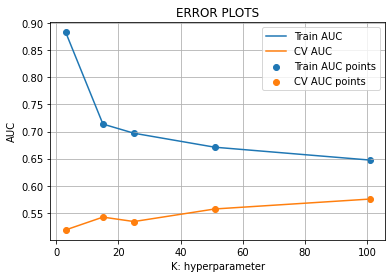

In [16]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []

K = [3, 15, 25, 51, 101]

for i in tqdm(K):

    neigh = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred    = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label = 'Train AUC')
plt.plot(K, cv_auc, label    = 'CV AUC')

plt.scatter(K, train_auc, label = 'Train AUC points')
plt.scatter(K, cv_auc, label    = 'CV AUC points')

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()

plt.show()

* Here as the K increases ROC score of test data increases and that of train data decreases so we have to find the value which neither overfits nor underfit.

* You might tempted to think 100 is the optimal value of K but if you observe carefull it kinda underfit the model as training ROC score is least when k = 100

##### 1.5.1.1.2 Method 1: Simple for loop (if you are having memory limitations use this)

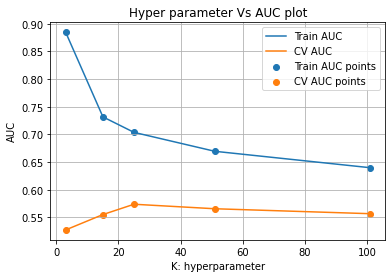

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.007186,0.001152,0.770246,0.043892,3,{'n_neighbors': 3},0.520280,0.526330,0.535064,0.527225,0.006069,5,0.894042,0.870311,0.889972,0.884775,0.010362
1,0.007875,0.002827,0.680914,0.116712,15,{'n_neighbors': 15},0.541954,0.557474,0.565624,0.555018,0.009818,4,0.741804,0.726600,0.726552,0.731652,0.007179
2,0.005253,0.000120,0.517313,0.005527,25,{'n_neighbors': 25},0.571074,0.569076,0.580850,0.573667,0.005144,1,0.710696,0.701959,0.698388,0.703681,0.005170
3,0.005218,0.000096,0.523556,0.004790,51,{'n_neighbors': 51},0.571752,0.545463,0.579339,0.565518,0.014515,2,0.661564,0.677937,0.668850,0.669450,0.006697
4,0.005956,0.000398,0.740307,0.156500,101,{'n_neighbors': 101},0.524520,0.578588,0.566606,0.556571,0.023186,3,0.639189,0.633383,0.646772,0.639781,0.005482


In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

neigh = KNeighborsClassifier(n_jobs = -1)

parameters = {'n_neighbors':[3, 15, 25, 51, 101]}
clf        = RandomizedSearchCV(neigh, parameters, cv = 3, scoring = 'roc_auc',return_train_score = True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors']) # sorting DataFrame according to the n_neighbors

train_auc     = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc        = results['mean_test_score'] 
cv_auc_std    = results['std_test_score']
K             = results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")

plt.title("Hyper parameter Vs AUC plot")

plt.grid()
plt.show()

results.head()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [ ]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 95

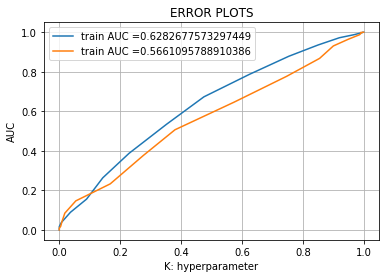

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.35336663001865454 for threshold 0.821
Train confusion matrix
[[ 158  143]
 [ 635 1308]]
Test confusion matrix
[[ 94 127]
 [505 924]]


<pre>

<h3><font color='blue'>IF Your system is getting stuck when you are working with the Knn: <font color='green'>YOU NEED TO USE BATCH WISE PREDICTION</font></font></h3>

neigh = KNeighborsClassifier(n_neighbors=i)
neigh.fit(X_train_bow, y_train)

# instead of predicting all the data points at a time, we will predict 1000 data points at a time
# you might need to change this code as per requirement
# please try to debug errors on your own, read the errors and try to understand it.
# you should be able to resolve them on your own as you wrote that code :)
# use as many print statements as possible and make sure whats happening in the code
# read the documentation of functions and get the sense out of it

y_train_pred = []
for i in range(0, X_train.shape[0], 1000):
    y_train_pred.extend(neigh.predict_proba(X_train_bow[i,i+1000])[:,1]) # this is a pseudo code

y_cv_pred = []
for i in range(0, X_cv.shape[0], 1000):
    y_cv_pred.extend(neigh.predict_proba(X_cv_bow[i,i+1000])[:,1]) # this is a pseudo code
    

train_auc.append(roc_auc_score(y_train,y_train_pred))
cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


</pre>

<h3>1.5.3 Appling KNN: AVG W2V featurization</h3>

In [ ]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))
print(avg_w2v_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:00<00:00, 3111.93it/s]


2244
300
[ 5.33005407e-03  4.12416054e-02 -4.43186585e-02 -1.28163527e-01
  4.99318519e-04  9.72417111e-02 -3.48786000e+00  8.64229481e-02
  4.15002444e-03 -1.00114556e-01  1.91419430e-02 -2.86498963e-03
  1.39764550e-01 -8.59202074e-02 -3.45245310e-02  1.77790363e-02
  4.13685341e-02 -2.69475741e-02  7.55039926e-02 -1.45699583e-02
  4.80989267e-02 -4.08999341e-02  5.25691704e-03 -1.36482867e-02
 -1.58332539e-02 -8.24228252e-02  4.36251111e-02 -5.62350861e-02
 -5.72651156e-02 -6.21192444e-02 -2.05361665e-01 -1.08848329e-01
  1.06707444e-01  1.18229319e-01 -4.04386444e-02 -5.20993415e-02
 -6.06704363e-02 -1.60813489e-02 -3.54120633e-02 -4.81497407e-02
 -1.20012448e-01  1.27431464e-01 -2.52194667e-02 -1.69653133e-01
  2.95028007e-02 -5.06121756e-02  5.12632926e-02 -2.75269015e-02
 -1.88450630e-02 -9.17787052e-02 -8.68596000e-03 -1.05312482e-01
  2.06985361e-02 -3.02243593e-02  5.08290519e-02 -1.18690386e-01
  1.52117747e-01 -3.56924130e-02 -1.70493037e-02  1.00048272e-01
 -4.51816126e-02

In [ ]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

100%|████████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 3380.66it/s]


In [ ]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 3109.62it/s]


In [ ]:
X_tr = hstack((avg_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 360) (2244,)
(1106, 360) (1106,)
(1650, 360) (1650,)


#### 1.5.3.1 Hyper parameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


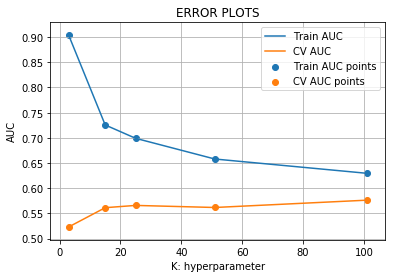

In [ ]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [ ]:
best_k = 101

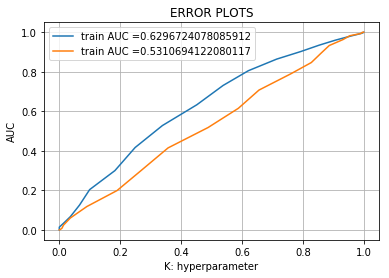

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.34910907713694106 for threshold 0.881
Train confusion matrix
[[ 199  102]
 [ 917 1026]]
Test confusion matrix
[[113 108]
 [689 740]]
